# Demo 2. Network burst inference from raw spike train data
### Richard's comments:
This demo is similar to the previous one, where we aim to do inference with a trained density estimator. But now, we target a real experimental recording. Specifically, we want to discover circuit models that can reproduce a multi-electrode array recording from the organoid dataset (unused in the publication), starting from spike times over 64 electrodes. 

We will walk through how to compute network burst summary statistics such that we can use them for inference, get samples from the trained density estimator, and then simulate and analyze a few of those discovered model configurations to check if they indeed reproduce the target observation.

For more details, visit the [AutoMIND preprint](https://www.biorxiv.org/content/10.1101/2024.08.21.608969v1).

---
Note: to run this notebook live, you will first need to download and unzip the trained DGMs and example dataset. You can find them from the data repository links on the [homepage](https://github.com/mackelab/automind), and you should place them in the appropriate directories by following the included instructions (or simply change the datapaths below).

### My comments: 
This notebook is specifically created for my particular dataset of 10 week develepment and I am looking for best matching 10 discovered models (posterior samples). In this particular one I am taking presimulated spikes from 10 x 10 discovered models saved in sim_collector saved from previous notebook, plotting them and doing analysis. 

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

#mpl_rc = "automind/assets/matplotlibrc"
#plt.style.use(mpl_rc)

import os
import numpy as np
import pandas as pd
from time import time
import pickle
from torch import Tensor
import seaborn as sns

import brian2 as b2
from automind.sim import b2_interface, runners
from automind.inference import inferer
from automind.utils import data_utils, analysis_utils, dist_utils, plot_utils
from automind.analysis import spikes_summary

---
# Load trained DGM and meta info, and dataset

In [2]:
data_dirs = "/nfs/scistore12/gaspgrp/tzuskino/automind/datasets/discovered_posterior_samples/organoids/"
path_dict = data_utils.extract_data_files(
    data_dirs,
    [
        "posterior.pickle",
        "params_dict_analysis_updated.pickle",
        "summary_data_merged.csv",
    ],
)
_, posterior, params_dict = data_utils.load_df_posteriors(path_dict)
print(posterior)

cols_features = list(posterior.x_bounds_and_transforms.keys())
print("-------------------------")
print(f'Density estimator was trained on these features: {cols_features}')

posterior.pickle ['5065886_posterior.pickle']
params_dict_analysis_updated.pickle ['5065886_MK1_params_dict_analysis_updated.pickle']
summary_data_merged.csv ['5065886_MK1_summary_data_merged.csv']
2502 samples per xo.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.
-------------------------
Density estimator was trained on these features: ['burst_interval_mean', 'burst_interval_cv', 'burst_width_mean', 'burst_offset_time_mean']


### Load and process target data from raw spike times
Here, we use another recording from the organoid dataset, and demonstrate how to start from raw spike times to computing summary features amenable to be used for inference.

In [3]:
# Load the list of spike files
spike_files_path = '/nfs/scistore12/gaspgrp/tzuskino/vogels_lab_rotation/simulations/spike_files.txt'
with open(spike_files_path, 'r') as file:
    spike_files = file.read().splitlines()

# Load the spike data from each file
spike_data = []
names_files = []
for i, spike_file in enumerate(spike_files):
    spikes_df = pd.read_parquet(spike_file)
    spike_dict = spikes_df.groupby('Neuron')['Time (s)'].apply(np.array).to_dict()
    spike_data.append(spike_dict)
    names_files.append(os.path.basename(os.path.dirname(os.path.dirname(spike_file))))

# Print the number of recordings loaded
print(f"Loaded {len(spike_data)} recordings.")

Loaded 10 recordings.


Next, we convert the list of spikes into the dictionary form, mimicing the simulated data, in order to use the analysis functions as is. Note that this is not necessary, as any custom processing can be used to analyze the data, as long as its final form is what the trained density estimator expects. Although in practice it's recommended to use the same or similar analysis functions and settings, as this will result in better matches to the simulations.

The convenience function `convert_spike_array_to_dict` creates a dictionary from a list of spike "times" and given a sampling rate, resulting in a dictionary with a population `exc_spikes` and spike times in seconds. Then, we can call the analysis function.

In [6]:
#spikes_dict = data_utils.convert_spike_array_to_dict(spikes_in_list, fs, 'exc_spikes') # 
#spikes_dict['t_end'] = t_end
#spikes_dict['inh_spikes'] = {}

# Analyze data with the same params_dict as the simulated data. 
# Note that depending on your own data, some settings may need to be adjusted in params_dict['params_analysis'].

params_dict['params_analysis']['analysis_window'] = np.array([0.1, None])

spikes_analyzed = []
for i in range(len(spike_data)):
    analyzed_data = analysis_utils.compute_spike_burst_features({'exc_spikes': spike_data[i], 't_end': 200}, params_dict)
    spikes_analyzed.append(analyzed_data)
    print(f'Analysis of recording {i} complete.')

Analysis of recording 0 complete.
Analysis of recording 1 complete.
Analysis of recording 2 complete.
Analysis of recording 3 complete.
Analysis of recording 4 complete.
Analysis of recording 5 complete.
Analysis of recording 6 complete.
Analysis of recording 7 complete.
Analysis of recording 8 complete.
Analysis of recording 9 complete.


### Adjust some of the recording's burst detection function after some inspection of each one of the samples average pop rate

Text(0.5, 1.0, 'Average population rate for recording 5')

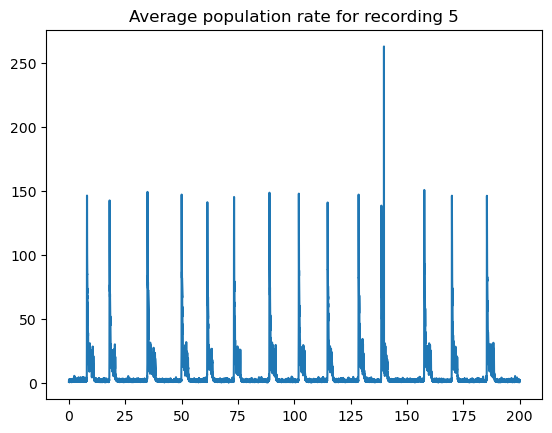

In [7]:
params_dict_5 = params_dict.copy()
params_dict_5['params_analysis']['min_burst_height_ratio'] = 0.5
spikes_analyzed[5] = analysis_utils.compute_spike_burst_features({'exc_spikes': spike_data[5], 't_end': 200}, params_dict_5)
plt.plot(spikes_analyzed[5][1]['t_ds'],spikes_analyzed[5][1]['avgpop_rate'])
plt.title('Average population rate for recording 5')
#rray([  8.037,  18.058,  34.862,  50.011,  61.415,  73.26 ,  88.965,101.993, 114.763, 128.506, 139.748, 157.639, 169.889, 185.413]),

Text(0.5, 1.0, 'Average population rate for recording 8')

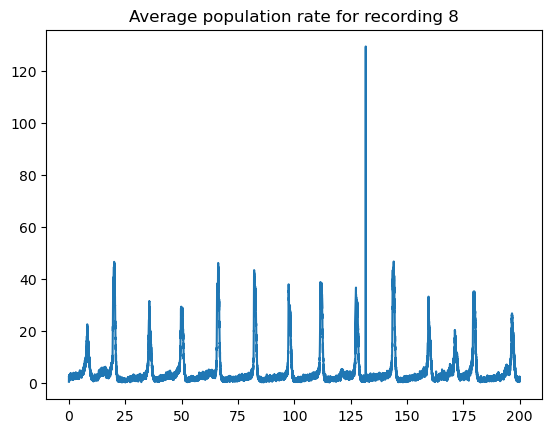

In [8]:
params_dict_8 = params_dict.copy()
params_dict_8['params_analysis']['min_burst_height_ratio'] = 0.1
spikes_analyzed[8] = analysis_utils.compute_spike_burst_features({'exc_spikes': spike_data[8], 't_end': 200}, params_dict_8)

plt.plot(spikes_analyzed[8][1]['t_ds'],spikes_analyzed[8][1]['avgpop_rate'])
plt.title('Average population rate for recording 8')


Text(0.5, 1.0, 'Average population rate for recording 9')

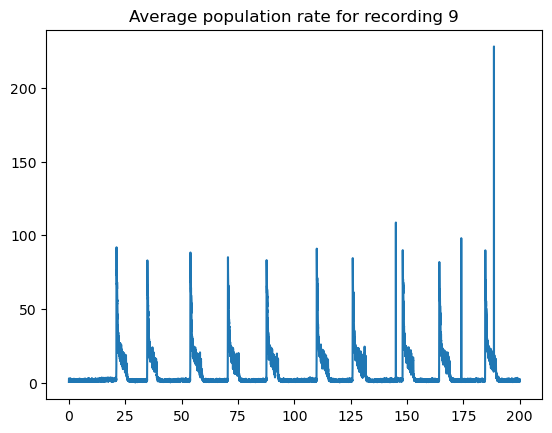

In [9]:
params_dict_9 = params_dict.copy()
params_dict_9['params_analysis']['min_burst_height_ratio'] = 0.2
spikes_analyzed[9] = analysis_utils.compute_spike_burst_features({'exc_spikes': spike_data[9], 't_end': 200}, params_dict_9)
plt.plot(spikes_analyzed[9][1]['t_ds'],spikes_analyzed[9][1]['avgpop_rate'])
plt.title('Average population rate for recording 9')


# Simulation Collector

In [4]:
# load sim_collector
with open('sim_collector.pickle', 'rb') as handle:
    sim_collector = pickle.load(handle)
# load ordered - saved ids of samples in which orderer are they the best fit 
with open('ordered.pickle', 'rb') as h:
    ordered = pickle.load(h)

In [5]:
results_collector = {}
for i in range(len(sim_collector)):
    results_collector[i] = [
        analysis_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector[i]
    ]

WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/analysis/spikes_summary.py:601: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "burst_corr_interval2nextpeak": stats.spearmanr(
 [py.warnings]
WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/analysis/spikes_summary.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "burst_corr_interval2prevpeak": stats.spearmanr(
 [py.warnings]
WARNING    /nfs/scistore12/gaspgrp/tzuskino/miniforge3/envs/automind/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
 [py.warnings]
WARNING    /nfs/scistore12/gaspgrp/tzuskino/automind/automind/analysis/spikes_summary.py:601: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  "burst_corr_interval2nextpeak": stats.spearmanr(
 [py.warnings]
WARNING    

In [ ]:
#this is like a side check to see if the data is being processed correctly
df_xos = spikes_analyzed[0][0] #one example of the data
print('this is the target observation')
print(df_xos[cols_features])
df_xos_preproc, _, _, _ = dist_utils.preproc_dataframe(
    df_xos,
    posterior.x_bounds_and_transforms,
    drop_nans=False,
    replace_infs=True,
)
xo = df_xos_preproc.loc[0][cols_features].values
xo_tensor = posterior.x_standardizing_func(Tensor(xo[None, :]))

print(f"Processed target observation has shape {xo_tensor.shape}: {xo_tensor}")
model_stats_check = np.ones((10, len(cols_features))) * (np.inf) #this np inf might be the clever solution
for i_sim, rc in enumerate(results_collector[0]):
    if not rc['summary_bursts'][cols_features].empty:
        model_stats_check[i_sim, :] = rc['summary_bursts'][cols_features].values
print('this is the model stats check (in normal units)')
print(model_stats_check)
ordered_check = np.argsort(np.abs(np.log10(model_stats_check) - xo).sum(axis=1))
print('this is the ordered models ids ', ordered_check)
#there is a problem taking the log of it because it is inf can get too high in the 

this is the target observation
   burst_interval_mean  burst_interval_cv  burst_width_mean  \
0             4.347568           0.451023          0.363287   

   burst_offset_time_mean  
0                0.294973  
Processed target observation has shape torch.Size([1, 4]): tensor([[-2.3771,  1.9649, -1.0030, -0.6864]])
this is the model stats check (in normal units)
[[ 0.6922872   0.21870733  0.75014015  0.33174645]
 [        inf         inf         inf         inf]
 [ 3.3209      0.02406781  0.91696134  0.78163848]
 [ 3.59167273  0.15857264  0.39190454  0.28714032]
 [ 0.77528405  1.15425325  0.10050195  0.06693709]
 [10.79105556  0.0430783   0.60594806  0.53736746]
 [ 0.6991014   0.24410668  0.21624945  0.09753115]
 [ 8.35904348  0.0448449   0.5157097   0.38816702]
 [ 4.393       0.12811239  0.63639359  0.58072439]
 [ 0.73887407  1.00736488  0.21576862  0.08544827]]
this is the ordered models ids  [3 8 0 7 6 9 5 2 4 1]


In [6]:
# there is a missmatch in the order of the weeks and the order of the files (the files are not in ordered by weeks)
ordered_by_weeks = {}
weeks_ordered_by_file_names = [9, 8, 3, 4, 6, 7, 1, 2, 0, 5]
for i, week in enumerate(weeks_ordered_by_file_names):
    ordered_by_weeks[week] = ordered[i]
ordered_by_weeks

{9: array([3, 8, 0, 7, 6, 9, 5, 2, 4, 1]),
 8: array([5, 0, 9, 2, 4, 3, 6, 1, 7, 8]),
 3: array([9, 8, 1, 0, 4, 5, 2, 3, 7, 6]),
 4: array([5, 0, 2, 1, 3, 4, 6, 7, 8, 9]),
 6: array([6, 0, 5, 1, 3, 2, 4, 7, 8, 9]),
 7: array([9, 1, 6, 2, 3, 4, 5, 0, 7, 8]),
 1: array([6, 2, 1, 0, 3, 4, 5, 7, 8, 9]),
 2: array([8, 1, 3, 7, 2, 4, 5, 0, 6, 9]),
 0: array([3, 2, 7, 9, 5, 1, 0, 6, 4, 8]),
 5: array([7, 1, 3, 8, 4, 2, 5, 0, 6, 9])}

In [55]:
#theses are the model burst statistic save as they come in the simulation
model_stats = {}
for w, week in enumerate(ordered_by_weeks.keys()):
    for i, idx in enumerate(ordered_by_weeks[week]):
        model_stats[(week, idx)] = results_collector[w][idx]['summary_bursts'][cols_features].values #results collector already has the computed bursts for all models
print(model_stats)

{(9, np.int64(3)): array([[3.59167273, 0.15857264, 0.39190454, 0.28714032]]), (9, np.int64(8)): array([[4.393     , 0.12811239, 0.63639359, 0.58072439]]), (9, np.int64(0)): array([[0.6922872 , 0.21870733, 0.75014015, 0.33174645]]), (9, np.int64(7)): array([[8.35904348, 0.0448449 , 0.5157097 , 0.38816702]]), (9, np.int64(6)): array([[0.6991014 , 0.24410668, 0.21624945, 0.09753115]]), (9, np.int64(9)): array([[0.73887407, 1.00736488, 0.21576862, 0.08544827]]), (9, np.int64(5)): array([[10.79105556,  0.0430783 ,  0.60594806,  0.53736746]]), (9, np.int64(2)): array([[3.3199    , 0.02461077, 0.91696134, 0.79016307]]), (9, np.int64(4)): array([[0.77528405, 1.15425325, 0.10050195, 0.06693709]]), (9, np.int64(1)): array([], shape=(0, 4), dtype=object), (8, np.int64(5)): array([[4.61216279, 0.28902431, 0.54639667, 0.47542963]]), (8, np.int64(0)): array([[8.82877273, 0.40221751, 0.52316564, 0.4435054 ]]), (8, np.int64(9)): array([[24.92442857,  0.71224284,  0.39372946,  0.28791667]]), (8, np.int

In [38]:
#this is loading the parameters of the discovered models
params_net_collector = {}

for w, week in enumerate(ordered_by_weeks.keys()):
    for i, idx in enumerate(ordered_by_weeks[week]):
        params_net_collector[(week, idx)] = sim_collector[w][idx][0] #results collector already has the computed bursts for all models

print(params_net_collector)

{(9, np.int64(3)): {'params_net': {'N_pop': 2000, 'exc_prop': np.float64(0.8900060653686523), 'p_e2e': np.float64(0.034446947276592255), 'p_e2i': np.float64(0.017867647111415863), 'p_i2e': np.float64(0.10089495778083801), 'p_i2i': np.float64(0.09698523581027985), 'n_clusters': np.float64(11.607725143432617), 'clusters_per_neuron': 2, 'R_pe2e': np.float64(1.8006236553192139), 'R_Qe2e': np.float64(1.7984449863433838), 'order_clusters': False}, 'params_Epop': {'C': 0.35234613 * nfarad, 'g_L': 6.929986 * nsiemens, 'v_rest': -73.92741394 * mvolt, 'v_thresh': -32.76298904 * mvolt, 'delta_T': 2.43316221 * mvolt, 'a': -8.65960217 * nsiemens, 'tau_w': 0.74877472 * second, 'b': 61.08775711 * pamp, 'v_reset': -68.32427979 * mvolt, 't_refrac': 4.79074574 * msecond, 'v_cut': -40. * mvolt, 'v_0_offset': [0. * volt, 4. * mvolt], 'E_ge': 0. * volt, 'E_gi': -74.08816528 * mvolt, 'Q_ge': 1.77310753 * nsiemens, 'Q_gi': 19.22303772 * nsiemens, 'tau_ge': 7.94953108 * msecond, 'tau_gi': 2.2302978 * msecond,

# Organoid data Analysis

In [65]:
best_ibi_mean  = {}

for w, week in enumerate(ordered_by_weeks.keys()):
    id = ordered_by_weeks[week][0]
    best_ibi_mean[week] = model_stats[(week,id)][0][0]
best_ibi_mean_array = np.array(list(dict(sorted(best_ibi_mean.items())).values()))
best_ibi_mean_array

array([12.3613125 , 13.83978571, 18.9281    , 15.21361538, 11.51958824,
       19.823     , 30.93583333, 18.9708    ,  4.61216279,  3.59167273])

WARNING    /tmp/ipykernel_229859/1200604493.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
 [py.warnings]


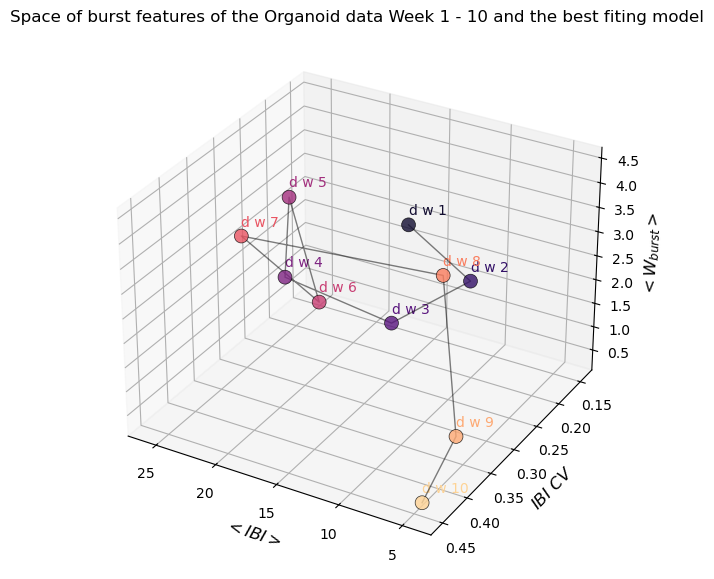

In [78]:

from mpl_toolkits.mplot3d import Axes3D
x = {}
y = {}
z = {}
for i, week in enumerate(ordered_by_weeks.keys()):
    x[week] = spikes_analyzed[i][0]['burst_interval_mean'][0]
    y[week] = spikes_analyzed[i][0]['burst_interval_cv'][0]
    z[week] = spikes_analyzed[i][0]['burst_width_mean'][0]
x_dict = dict(sorted(x.items()))
y_dict = dict(sorted(y.items()))
z_dict = dict(sorted(z.items()))
# Convert lists to numpy arrays
x_array = np.array(list(x_dict.values()))
y_array = np.array(list(y_dict.values()))
z_array = np.array(list(z_dict.values()))

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot points with customized style
scatter = ax.scatter(
    x_array, y_array, z_array, 
    c=colors,
    cmap='magma',                # Colormap for pretty colors
    s=100,                         # Size of points
    alpha=0.8,                     # Transparency
    edgecolors='k',                # Black edges for better visibility
    linewidth=0.5
)

# Plot a line connecting the points in order
ax.plot(x_array, y_array, z_array, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add colorbar
#cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
#cbar.set_label('Distance from Origin', rotation=270, labelpad=15)

# Set axis labels
ax.set_xlabel('$<IBI>$', fontsize=12)
ax.set_ylabel('$IBI$ $CV$', fontsize=12)
ax.set_zlabel('$<W_{burst}>$', fontsize=12)

# Set a title
ax.set_title('Space of burst features of the Organoid data Week 1 - 10 and the best fiting model', wrap=True,fontsize=12)

# Set grid style
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the viewpoint
ax.view_init(elev=30, azim=120)  # Elevation and Azimuthal angles

# Add numbers to the points in the order they appear
for i in range(0,10):
    ax.text(x_array[i], y_array[i], z_array[i]+0.2, 'd w %d' % (i + 1), size=10, zorder=1, color=colors[i])

# plot the best fit models in the space
best_ibi_mean,best_ibi_cv,best_burst_width_mean  = {},{},{} 
for w, week in enumerate(ordered_by_weeks.keys()):
    id = ordered_by_weeks[week][0]
    best_ibi_mean[week] = model_stats[(week,id)][0][0]
    best_ibi_cv[week] = model_stats[(week,id)][0][1]
    best_burst_width_mean[week] = model_stats[(week,id)][0][2]
best_ibi_mean_array = np.array(list(dict(sorted(best_ibi_mean.items())).values()))
best_ibi_cv_array = np.array(list(dict(sorted(best_ibi_cv.items())).values()))
best_burst_width_mean_array = np.array(list(dict(sorted(best_burst_width_mean.items())).values()))
'''
scatter2 = ax.scatter(
    best_ibi_mean_array, best_ibi_cv_array, best_burst_width_mean_array, 
    c=colors,  # Color points based on distance from origin
    cmap='magma',                # Colormap for pretty colors
    s=100,                         # Size of points
    alpha=0.8,                     # Transparency
    edgecolors='k',                # Black edges for better visibility
    linewidth=0.5,
    marker='^'                     # Triangle marker
)
for i in range(10):
    ax.text(best_ibi_mean_array[i],best_ibi_cv_array[i],best_burst_width_mean_array[i]+0.2, 'm w %d' % (i + 1), size=10, zorder=1, color=colors[i])
# Plot a line connecting the points in order
ax.plot(best_ibi_mean_array,best_ibi_cv_array,best_burst_width_mean_array, color='black', linestyle='--', linewidth=1, alpha=0.5)
'''
fig.savefig('3D_burst_features_organoid_data_colorscheme.png', dpi=300, bbox_inches='tight')
plt.show()

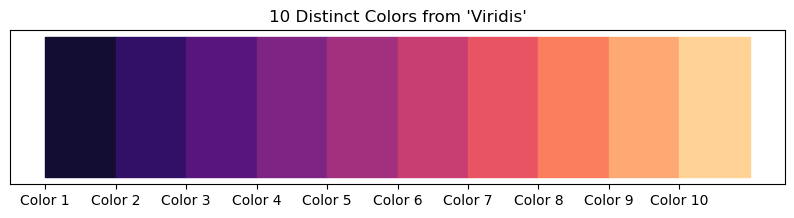

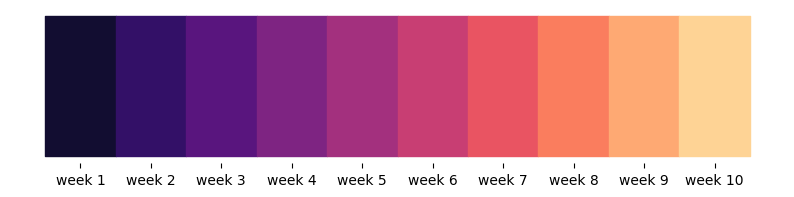

In [7]:
# Get 10 distinct colors from the colormap
colors = sns.color_palette("magma", 10)

# Plot the colors
plt.figure(figsize=(10, 2))
for i, color in enumerate(colors):
    plt.fill_between([i, i + 1], 0, 1, color=color)
plt.xticks(range(10), [f"Color {i+1}" for i in range(10)])
plt.yticks([])
plt.title("10 Distinct Colors from 'Viridis'")

# Plot another graph with ticks in the middle
plt.figure(figsize=(10, 2))
for i, color in enumerate(colors):
    plt.fill_between([i, i + 1], 0, 1, color=color)
plt.xticks([i + 0.5 for i in range(10)], [f"week {i+1}" for i in range(10)])
plt.yticks([])
# Remove the spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()



# Analysis of the models

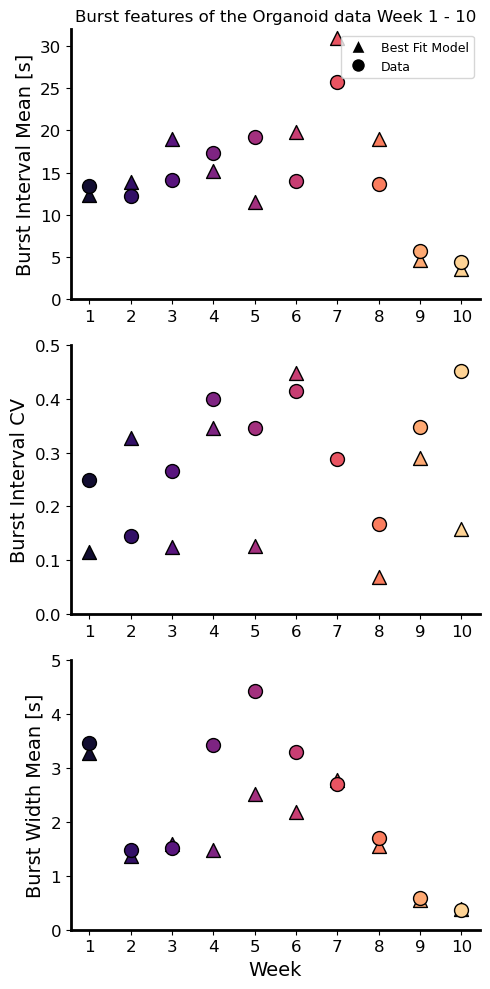

In [ ]:
from matplotlib.lines import Line2D


weeks = list(range(1, 11))

# Create a figure and axis objects
fig, axs = plt.subplots(3, 1, figsize=(5, 10))

# Customize the spines
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)

# Create violin plots for burst
'''
data_violin_ibi_mean, data_violin_ibi_cv, data_violin_burst_width = {}, {}, {}
for week in ordered_by_weeks.keys():
    data_violin_ibi_mean[week] = np.array([model_stats[(week, idx)][0][0] if (week, idx) in model_stats and model_stats[(week, idx)].size > 0 else np.nan for idx in ordered_by_weeks[week]])
    data_violin_ibi_cv[week] = np.array([model_stats[(week, idx)][0][1] if (week, idx) in model_stats and model_stats[(week, idx)].size > 0 else np.nan for idx in ordered_by_weeks[week]])
    data_violin_burst_width[week] = np.array([model_stats[(week, idx)][0][2] if (week, idx) in model_stats and model_stats[(week, idx)].size > 0 else np.nan for idx in ordered_by_weeks[week]])
# Order the data_violin dictionaries based on the key
data_violin_ibi_mean = dict(sorted(data_violin_ibi_mean.items()))
data_violin_ibi_cv = dict(sorted(data_violin_ibi_cv.items()))
data_violin_burst_width = dict(sorted(data_violin_burst_width.items()))

group_names = list(data_violin_ibi_mean.keys())
values_ibi_mean = np.concatenate(list(data_violin_ibi_mean.values()))
values_ibi_cv = np.concatenate(list(data_violin_ibi_cv.values()))
values_burst_width = np.concatenate(list(data_violin_burst_width.values()))
groups = np.concatenate([[name] * len(data_violin_ibi_mean[name]) for name in group_names])

sns.violinplot(x=groups, y=values_ibi_mean, palette=[colors[week-1] for week in weeks], ax=axs[0], inner='point', alpha=0.2)
sns.violinplot(x=groups, y=values_ibi_cv, palette=[colors[week-1] for week in weeks], ax=axs[1], inner='point', alpha=0.2)
sns.violinplot(x=groups, y=values_burst_width, palette=[colors[week-1] for week in weeks], ax=axs[2], inner='point', alpha=0.2)'''
axs[0].set_xticks(range(1, 11))
axs[1].set_xticks(range(1, 11))
axs[2].set_xticks(range(1, 11))
axs[0].set_xticklabels(weeks)
axs[1].set_xticklabels(weeks)
axs[2].set_xticklabels(weeks)

for i in range(10):
    axs[0].scatter(i+1, best_ibi_mean_array[i], color=colors[i], s=100, edgecolor='k',marker='^')   
    axs[1].scatter(i+1, best_ibi_cv_array[i], color=colors[i], s=100, edgecolor='k',marker='^')
    axs[2].scatter(i+1, best_burst_width_mean_array[i], color=colors[i], s=100, edgecolor='k',marker='^')
    # Add legend
legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='Best Fit Model', markerfacecolor='k', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Data', markerfacecolor='k', markersize=10)
    ]
axs[0].legend(handles=legend_elements, loc='upper right',fontsize=9)
# Plot burst interval mean values for data
for i in range(len(weeks)):
    axs[0].scatter(i+1, x_array[i], color=colors[i], s=100, edgecolor='k')

# Plot burst interval CV values
for i in range(len(weeks)):
    axs[1].scatter(i+1, y_array[i], color=colors[i], s=100, edgecolor='k')

# Plot burst width mean values
for i in range(len(weeks)):
    axs[2].scatter(i+1, z_array[i], color=colors[i], s=100, edgecolor='k')

axs[0].set_ylabel('Burst Interval Mean [s]')
axs[1].set_ylabel('Burst Interval CV')
axs[2].set_xlabel('Week')
axs[2].set_ylabel('Burst Width Mean [s]')

# Set y-axis limits for all subplots
axs[0].set_ylim(0, 32)  # Adjust as needed based on your data range
axs[1].set_ylim(0, 0.5)   # Adjust as needed based on your data range
axs[2].set_ylim(0, 5)   # Adjust as needed based on your data range

# Increase the tick size for all subplots
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)
axs[0].set_title('Burst features of the Organoid data Week 1 - 10')
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
# Save the figure
#fig.savefig('burst_features_over_weeks_with_model.png', dpi=300, bbox_inches='tight')

WARNING    /tmp/ipykernel_2133075/1755387762.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data), '.k', color=colors[i], markersize=0.005)
 [py.warnings]
WARNING    /tmp/ipykernel_2133075/1755387762.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[index+1].plot(spike_train, np.ones_like(spike_train) * (neuron_id), '.k', color=colors[i], markersize=0.005)
 [py.warnings]


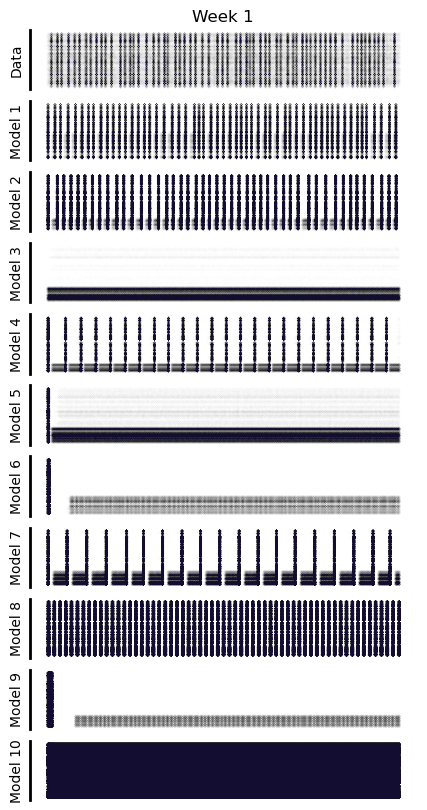

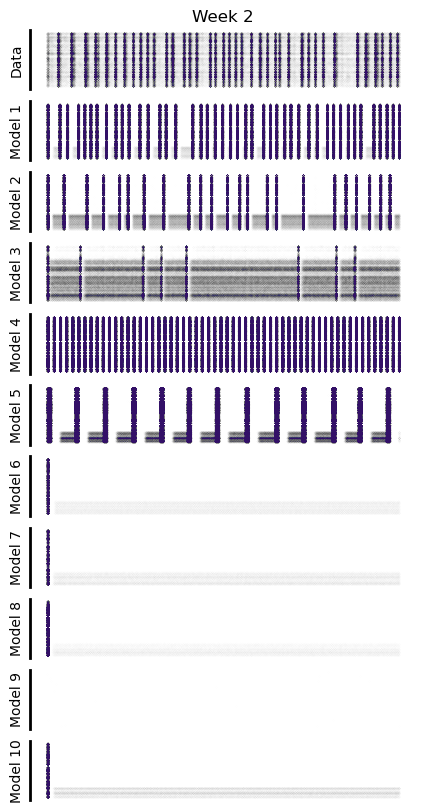

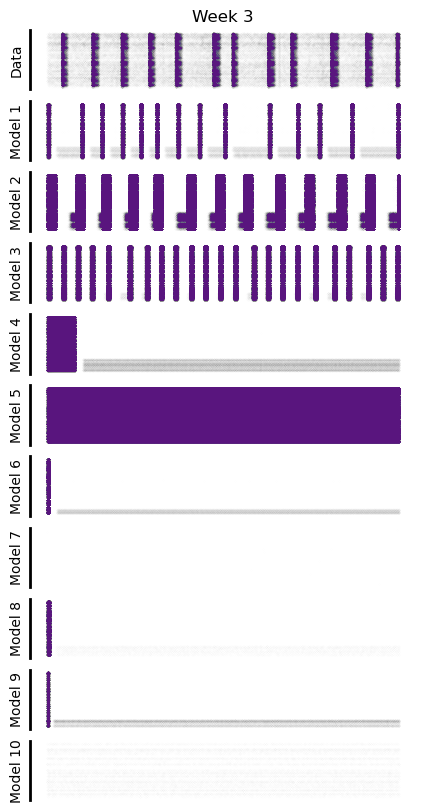

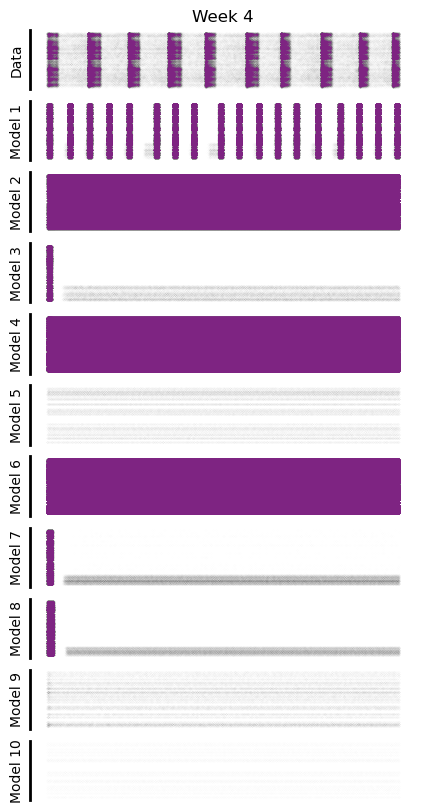

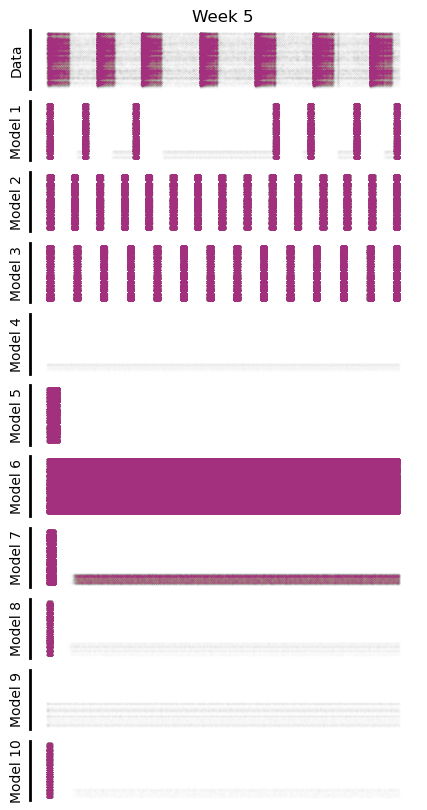

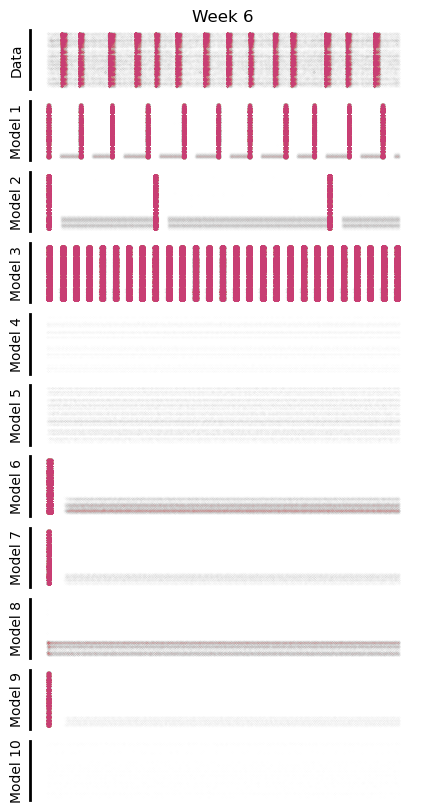

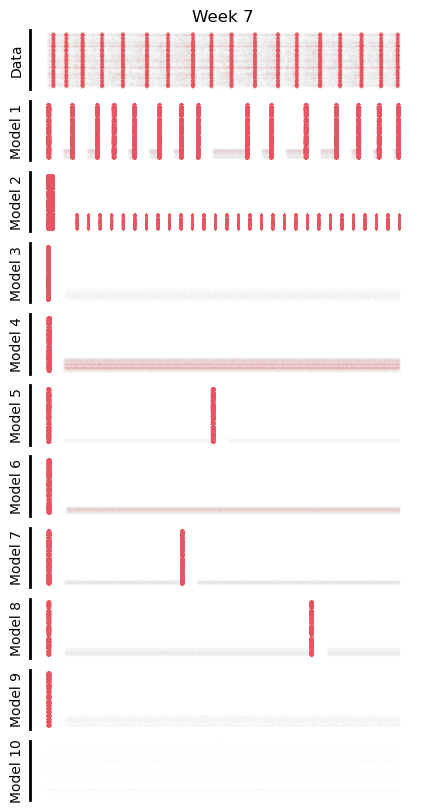

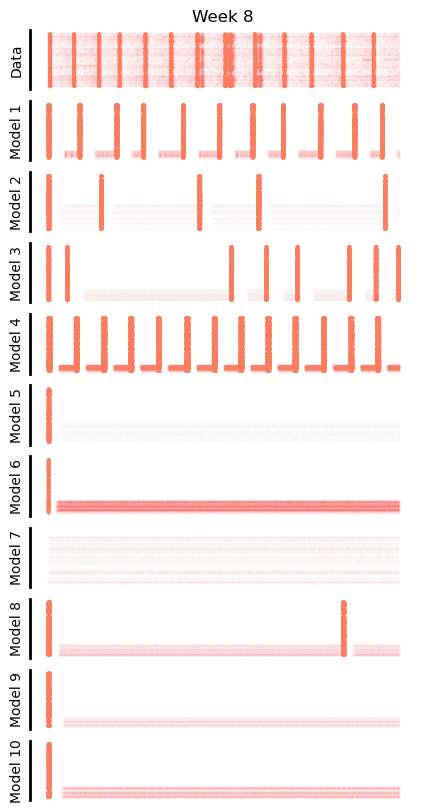

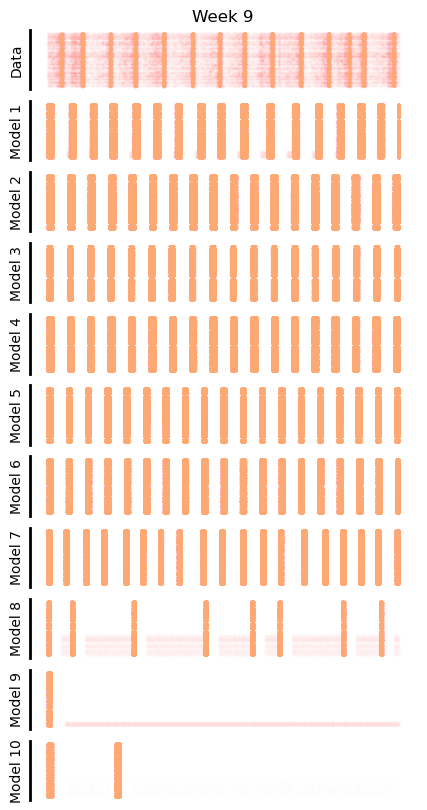

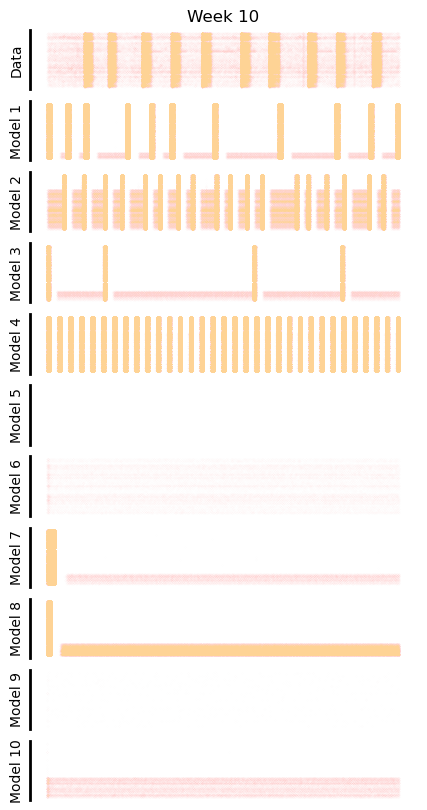

In [8]:
#rasters
for i in range(10):
    fig, axs = plt.subplots(11, 1, figsize=(5, 10))
    for neuron_id_data,spike_train in spike_data[i].items(): 
        spike_times = spike_train[spike_train <= 200]  # Filter spike times to 200 seconds
        if neuron_id_data % 5 == 0:  # Plot every 10th data point
            axs[0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data), '.k', color=colors[i], markersize=0.005)

    for index,i_sim in enumerate(ordered[i]):
        for neuron_id, spike_train in sim_collector[i][i_sim][1]['exc_spikes'].items():
            axs[index+1].plot(spike_train, np.ones_like(spike_train) * (neuron_id), '.k', color=colors[i], markersize=0.005)
        axs[index+1].set_ylabel(f'Model {index+1}')
            
            # Customize the spines
        axs[index+1].spines['top'].set_visible(False)
        axs[index+1].spines['right'].set_visible(False)
        axs[index+1].spines['bottom'].set_visible(False)
        axs[index+1].spines['left'].set_linewidth(2)
        axs[index+1].set_yticks([])
        axs[index+1].set_xticks([])
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_linewidth(2)
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    axs[0].set_title('Week {}'.format(i+1))
    axs[0].set_ylabel('Data')
    # Save the figure
    fig.savefig('model_rasters_week_{}.png'.format(i+1), dpi=300, bbox_inches='tight')


WARNING    /tmp/ipykernel_2929850/3696317301.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[i, 0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data), '.k', color=colors[i], markersize=0.005)
 [py.warnings]
WARNING    /tmp/ipykernel_2929850/3696317301.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[i, 1].plot(spike_train, np.ones_like(spike_train) * (neuron_id), '.k', color=colors[i], markersize=0.005)
 [py.warnings]


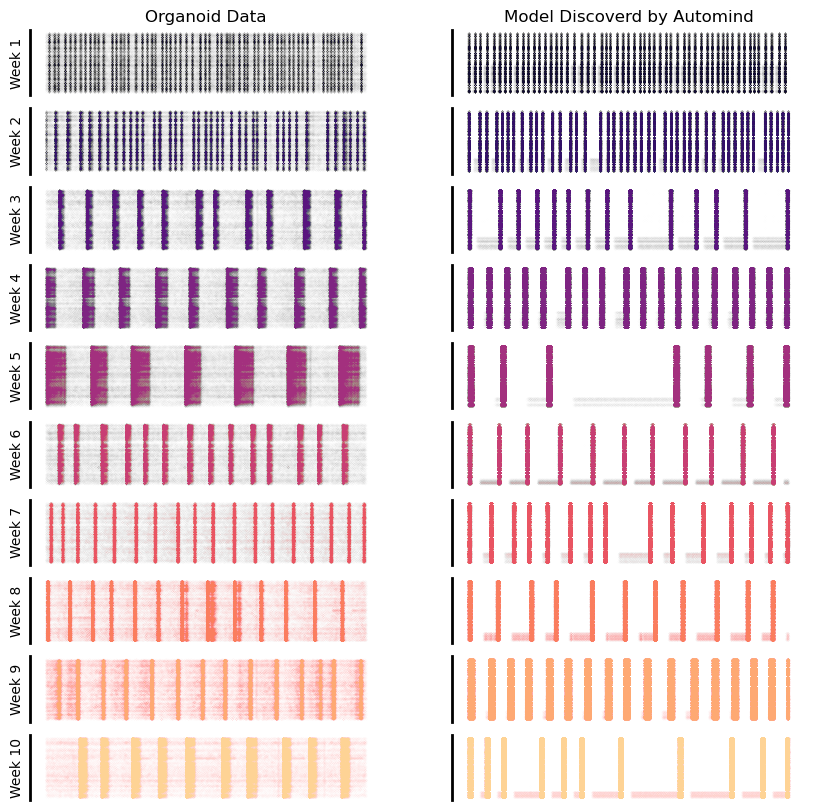

In [ ]:
#only plot the top ones Fig3 a
fig, axs = plt.subplots(10, 2, figsize=(10, 10))
#data
for i in range(10):
    for neuron_id_data, spike_train in spike_data[i].items(): 
        spike_times = spike_train[spike_train <= 200]  # Filter spike times to 200 seconds
        if neuron_id_data % 5 == 0:  # Plot every 5th data point
            axs[i, 0].plot(spike_times, np.ones_like(spike_times) * (neuron_id_data), '.k', color=colors[i], markersize=0.005)
    for neuron_id, spike_train in sim_collector[i][ordered[i][0]][1]['exc_spikes'].items():
        axs[i, 1].plot(spike_train, np.ones_like(spike_train) * (neuron_id), '.k', color=colors[i], markersize=0.005)
        
    # Customize the spines
    axs[i, 0].spines['top'].set_visible(False)
    axs[i, 0].spines['right'].set_visible(False)
    axs[i, 0].spines['bottom'].set_visible(False)
    axs[i, 0].spines['left'].set_linewidth(2)
    axs[i, 0].set_yticks([])
    axs[i, 0].set_xticks([])
    axs[i, 0].set_ylabel('Week {}'.format(i+1))
    axs[0, 0].set_title('Organoid Data')
    axs[0, 1].set_title('Model Discoverd by Automind')

    axs[i, 1].spines['top'].set_visible(False)
    axs[i, 1].spines['right'].set_visible(False)
    axs[i, 1].spines['bottom'].set_visible(False)
    axs[i, 1].spines['left'].set_linewidth(2)
    axs[i, 1].set_yticks([])
    axs[i, 1].set_xticks([])

# Save the figure
#fig.savefig('fig3_a_b.png'.format(week), dpi=300, bbox_inches='tight')


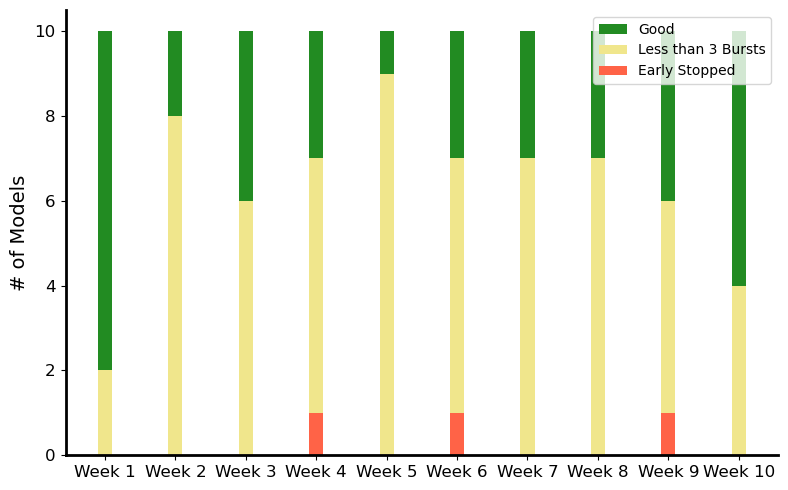

In [137]:
# Sample data for the bar plots
values = {'early_stopped':[0,0,0,1,0,1,0,0,1,0],'less_3_bursts':[2,8,6,6,9,6,7,7,5,4],'good':[8,2,4,3,1,3,3,3,4,6]} # All bars will have the same height
# Define the positions of the bars
bar_width = 0.2
index = np.arange(10)

# Create the bar plots
fig, ax = plt.subplots(figsize=(8,5))

# Plot the bars with multiple values per bar
bars = []
for i in range(len(index)):
    bar = ax.bar(index[i], values['good'][i], bar_width, bottom=np.array(values['early_stopped'])[i] + np.array(values['less_3_bursts'])[i], label='Good' if i == 0 else "", color='forestgreen')
    bar = ax.bar(index[i], values['less_3_bursts'][i], bar_width, bottom=values['early_stopped'][i], label='Less than 3 Bursts' if i == 0 else "", color='khaki')
    bar = ax.bar(index[i], values['early_stopped'][i], bar_width, label='Early Stopped' if i == 0 else "", color='tomato')
    bars.append(bar)

# Add labels, title, and legend
ax.set_ylabel('# of Models')
ax.set_xticks(index)
ax.set_xticklabels([f'Week {i+1}' for i in range(10)])
ax.legend(loc='upper right')
# Customize the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# Increase the size of the axis labels and titles
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

# Save the figure
fig.savefig('model_performance_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot the discovered model simulations
Finally, we plot the simulated spike trains and the population firing rate of each discovered model. 

Note that we will first re-order the simulations based on their similarity to the real data (to show the best models first). We will plot the real data to the right for comparison.

In [283]:
params = merged_df_samples[['params_Epop.g_L', 'params_Epop.tau_w', 'params_Epop.tau_w', 'params_Epop.tau_ge', 'params_net.exc_prop', 'params_Epop.p_igniters']]
params

,params_Epop.g_L,params_Epop.tau_w,params_Epop.tau_w,params_Epop.tau_ge,params_net.exc_prop,params_Epop.p_igniters
0,6.370496,1073.307251,1073.307251,3.319798,0.829724,0.240743
1,1.264197,1340.785400,1340.785400,5.648363,0.971906,0.264789
2,1.773314,1570.954102,1570.954102,10.002233,0.774095,0.182549
3,6.929986,748.774719,748.774719,7.949531,0.890006,0.471676
4,1.201509,2830.920654,2830.920654,4.796106,0.955934,0.207696
...,...,...,...,...,...,...
95,21.372490,1567.137817,1567.137817,8.017802,0.740865,0.210473
96,10.525087,941.272888,941.272888,4.385369,0.738713,0.751846
97,28.809168,1813.195557,1813.195557,8.182111,0.913035,0.110721
98,13.961790,1791.343750,1791.343750,9.314712,0.794669,0.722765


In [10]:
first_values = {week: ordered_by_weeks[week][0]+10*i for i,week in enumerate(ordered_by_weeks)}
combined_array = np.array(list(first_values.values()))
combined_array

array([ 7, 13, 25, 36, 46, 58, 65, 79, 83, 99])

WARNING    /tmp/ipykernel_4048978/3587812345.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=values_gL, palette=[colors[week-1] for week in weeks], ax=axs[0, 0], inner='point', alpha=0.2)
 [py.warnings]
WARNING    /tmp/ipykernel_4048978/3587812345.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=values_tauw, palette=[colors[week-1] for week in weeks], ax=axs[0, 1], inner='point', alpha=0.2)
 [py.warnings]
WARNING    /tmp/ipykernel_4048978/3587812345.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplo

done  params_Epop.g_L
done  params_Epop.tau_w
done  params_Epop.C
done  params_Epop.tau_ge
done  params_net.exc_prop
done  params_Epop.p_igniters


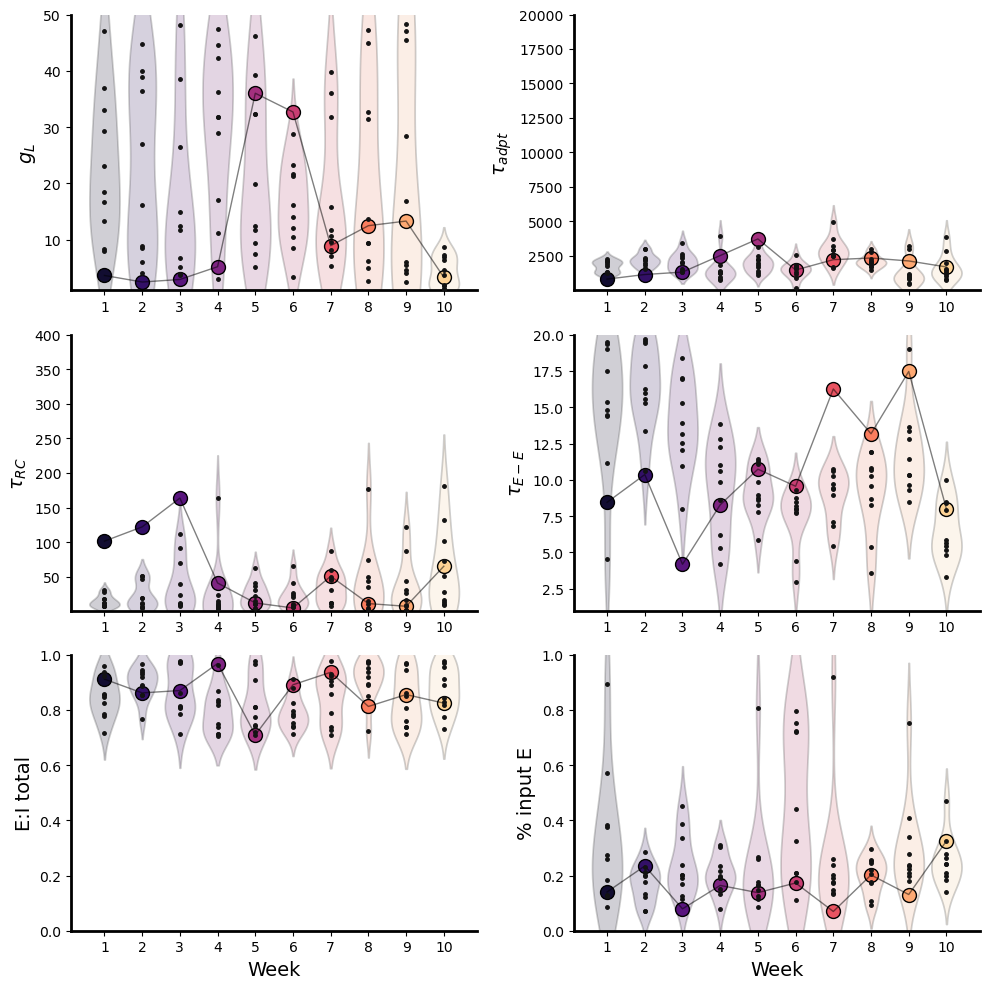

In [ ]:
#circuit parameter predictions
#gL, T_adapt, T E-E, T_RC, E:I total, % input E, t RC = C/gL
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure merged_df_samples, params_net_collector, ordered_by_weeks, combined_array, and colors are defined
# Example definitions (replace with actual data)
# merged_df_samples = ...
# params_net_collector = ...
# ordered_by_weeks = ...
# combined_array = ...
# colors = ...

# Extract the required parameters from the merged dataframe
params = merged_df_samples[['params_settings.random_seed','params_Epop.g_L', 'params_Epop.tau_w', 'params_Epop.C','params_Epop.tau_ge', 'params_net.exc_prop', 'params_Epop.p_igniters']]
# Plot each parameter against weeks separately
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
weeks = list(range(1, 11))
# Customize the spines
for row in axs:
    for ax in row:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.xaxis.label.set_size(14)
        ax.yaxis.label.set_size(14)

# Set specific limits for each y-axis
y_limits = [
    (1, 50),  # Limits for $g_L$
    (5, 20000),  # Limits for $\tau_{adpt}$
    (1, 400),  # Limits for $ \tau_{RC}$
    (1, 20),  # Limits for $\tau_{E-E}$
    (0, 1),  # Limits for E:I total
    (0, 1)  # Limits for % input E
]

# Apply the limits to each subplot
for i, ax in enumerate(axs.flat):
    ax.set_ylim(y_limits[i])

# List of parameter names for labeling
param_names = [r'$g_L$', r'$\tau_{adpt}$', r'$ \tau_{RC}$', r'$\tau_{E-E}$', r'E:I total', r'% input E']
params_net_collector

# Create violin plots for burst
data_violin_gL, data_violin_tauw, data_violin_tauRC,data_violin_tau_ge,data_violin_exc_prop,data_violin_input = {}, {}, {},{}, {}, {}

for week in ordered_by_weeks.keys():
    data_violin_gL[week] = np.array([params_net_collector[(week, idx)]['params_Epop']['g_L']/b2.nS if (week, idx) in params_net_collector and params_net_collector[(week, idx)]['params_Epop']['g_L']/b2.nS .size > 0 else np.nan for idx in ordered_by_weeks[week]])
    data_violin_tauw[week] = np.array([params_net_collector[(week, idx)]['params_Epop']['tau_w']/b2.ms if (week, idx) in params_net_collector and params_net_collector[(week, idx)]['params_Epop']['tau_w']/b2.ms .size > 0 else np.nan for idx in ordered_by_weeks[week]])
    data_violin_tauRC[week] = np.array([params_net_collector[(week, idx)]['params_Epop']['C']/params_net_collector[(week, idx)]['params_Epop']['g_L']/b2.ms if (week, idx) in params_net_collector and params_net_collector[(week, idx)]['params_Epop']['C']/params_net_collector[(week, idx)]['params_Epop']['g_L']/b2.ms.size > 0 else np.nan for idx in ordered_by_weeks[week]])
    data_violin_tau_ge[week] = np.array([params_net_collector[(week, idx)]['params_Epop']['tau_ge']/b2.ms if (week, idx) in params_net_collector and params_net_collector[(week, idx)]['params_Epop']['tau_ge']/b2.ms.size > 0 else np.nan for idx in ordered_by_weeks[week]])
    data_violin_exc_prop[week] = np.array([params_net_collector[(week, idx)]['params_net']['exc_prop'] if (week, idx) in params_net_collector and params_net_collector[(week, idx)]['params_net']['exc_prop'].size > 0 else np.nan for idx in ordered_by_weeks[week]])
    data_violin_input[week] = np.array([params_net_collector[(week, idx)]['params_Epop']['p_igniters'] if (week, idx) in params_net_collector and params_net_collector[(week, idx)]['params_Epop']['p_igniters'].size > 0 else np.nan for idx in ordered_by_weeks[week]])

# Order the data_violin dictionaries based on the key
data_violin_gL = dict(sorted(data_violin_gL.items()))
data_violin_tauw = dict(sorted(data_violin_tauw.items()))
data_violin_tau_ge = dict(sorted(data_violin_tau_ge.items()))
data_violin_tauRC = dict(sorted(data_violin_tauRC.items()))
data_violin_exc_prop = dict(sorted(data_violin_exc_prop.items()))
data_violin_input = dict(sorted(data_violin_input.items()))

group_names = list(data_violin_gL.keys())

values_gL = np.concatenate(list(data_violin_gL.values()))
values_tauw = np.concatenate(list(data_violin_tauw.values()))
values_tauRC = np.concatenate(list(data_violin_tauRC.values()))
values_tau_ge = np.concatenate(list(data_violin_tau_ge.values()))
values_exc_prop = np.concatenate(list(data_violin_exc_prop.values()))
values_input = np.concatenate(list(data_violin_input.values()))

groups = np.concatenate([[name] * len(data_violin_gL[name]) for name in group_names])

sns.violinplot(x=groups, y=values_gL, palette=[colors[week-1] for week in weeks], ax=axs[0, 0], inner='point', alpha=0.2)
sns.violinplot(x=groups, y=values_tauw, palette=[colors[week-1] for week in weeks], ax=axs[0, 1], inner='point', alpha=0.2)
sns.violinplot(x=groups, y=values_tauRC, palette=[colors[week-1] for week in weeks], ax=axs[1, 0], inner='point', alpha=0.2)
sns.violinplot(x=groups, y=values_tau_ge, palette=[colors[week-1] for week in weeks], ax=axs[1, 1], inner='point', alpha=0.2)
sns.violinplot(x=groups, y=values_exc_prop, palette=[colors[week-1] for week in weeks], ax=axs[2, 0], inner='point', alpha=0.2)
sns.violinplot(x=groups, y=values_input, palette=[colors[week-1] for week in weeks], ax=axs[2, 1], inner='point', alpha=0.2)

axs[0, 0].set_xticklabels(weeks)
axs[0, 1].set_xticklabels(weeks)
axs[1, 0].set_xticklabels(weeks)
axs[1, 1].set_xticklabels(weeks)
axs[2, 0].set_xticklabels(weeks)
axs[2, 1].set_xticklabels(weeks)

# Plot each parameter
for i, param in enumerate(params.columns[1:]):
    row = i // 2
    col = i % 2
    for j in range(10):
        if param == 'params_Epop.C':
            axs[row, col].scatter(j, params[param].iloc[combined_array[j]] / params['params_Epop.g_L'].iloc[combined_array[j]], s=100, edgecolor='k', color=colors[j])
        else:
            axs[row, col].scatter(j, params[param].iloc[combined_array[j]], s=100, edgecolor='k', color=colors[j])
    # Plot a black line connecting the points
    if param == 'params_Epop.C':
        axs[row, col].plot(range(10), [params[param].iloc[combined_array[j]] / params['params_Epop.g_L'].iloc[combined_array[j]] for j in range(10)], color='black', linestyle='-', linewidth=1, alpha=0.5)
    else:
        axs[row, col].plot(range(10), [params[param].iloc[combined_array[j]] for j in range(10)], color='black', linestyle='-', linewidth=1, alpha=0.5)
    print('done ', param)
    
    axs[row, col].set_ylabel(param_names[i])
    axs[row, col].set_xticks(range(10))
    axs[row, col].set_xticklabels([1,2,3,4,5,6,7,8,9,10])

# Create violin plots for each paramete

axs[2, 1].set_xlabel('Week')
axs[2, 0].set_xlabel('Week')

# Adjust layout
plt.tight_layout()
plt.show()
# Save the figure
#fig.savefig('circuit_parameter_predictions_with_violins.png', dpi=300, bbox_inches='tight')


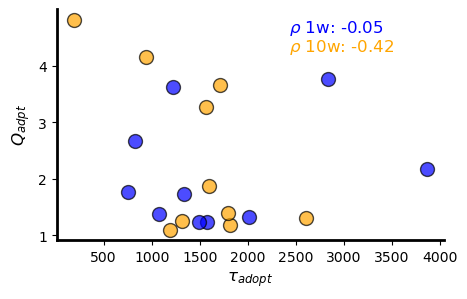

<Figure size 640x480 with 0 Axes>

In [149]:
from scipy.stats import spearmanr

# Extract the required parameters from the dataframe
Q_adopt_early = merged_df_samples['params_Epop.Q_ge'][:10]
Q_adopt_late = merged_df_samples['params_Epop.Q_ge'][90:]
tau_adopt_early = merged_df_samples['params_Epop.tau_w'][:10]
tau_adopt_late = merged_df_samples['params_Epop.tau_w'][90:]

# Create a scatter plot
plt.figure(figsize=(5, 3))
plt.scatter( tau_adopt_late,Q_adopt_late, c='orange', edgecolor='k', alpha=0.7, s=100)
plt.scatter( tau_adopt_early,Q_adopt_early, c='blue', edgecolor='k', alpha=0.7, s=100)
# Calculate Spearman's rank correlation coefficient

rho_early, _ = spearmanr(tau_adopt_early, Q_adopt_early)
rho_late, _ = spearmanr(tau_adopt_late, Q_adopt_late)
# Set limits for both axes
#plt.xlim([0, 20000])
#plt.ylim([0, 200])
# Add Spearman's rho to the plot
plt.text(0.6, 0.9, r'$\rho$ 1w: {}'.format(round(rho_early,2)), transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.text(0.6, 0.82, r'$\rho$ 10w: {}'.format(round(rho_late,2)), transform=plt.gca().transAxes, fontsize=12, color='orange')
plt.ylabel(r'$Q_{adpt}$',fontsize=12)
plt.xlabel(r'$\tau_{adopt}$',fontsize=12)
# Customize the spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()
# Save the figure
plt.savefig('scatter_plot.png', dpi=300)

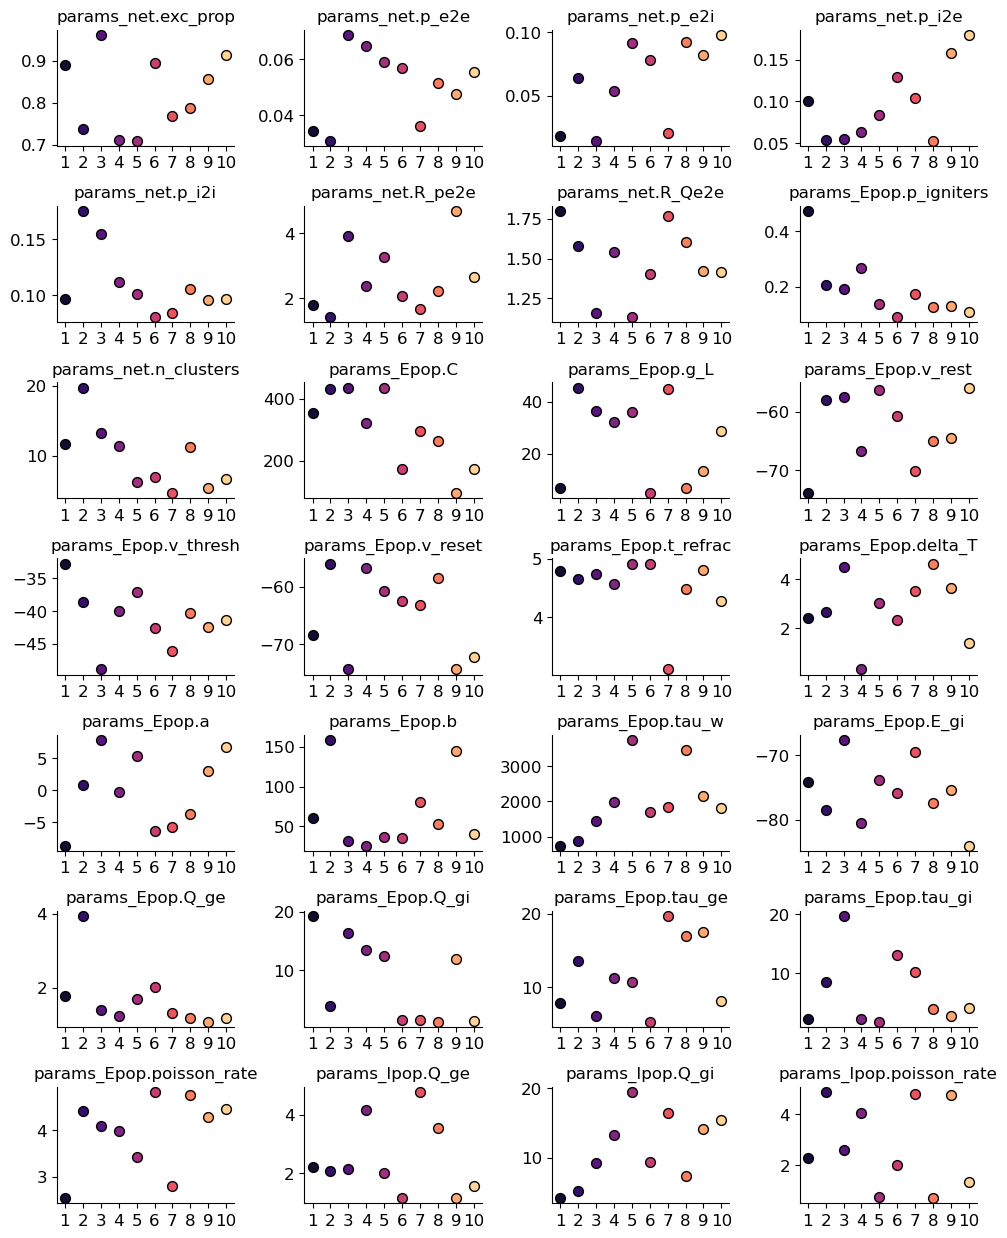

In [ ]:
random_seeds_good_samples = [628, 465,931,753,625,863,740,879,356,748] 
ids_good_samples = [merged_df_samples.index[merged_df_samples['params_settings.random_seed'] == seed][0] for seed in random_seeds_good_samples]
# Extract the required parameters from the merged dataframe
params = merged_df_samples.iloc[ids_good_samples, 4:]
# Create subplots with 4 columns
fig, axs = plt.subplots(len(params.columns) // 4 + 1, 4, figsize=(10, len(params.columns) * 0.5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Customize the x and y labels
for ax in axs:
    ax.spines['top'].set_linewidth(False)
    ax.spines['right'].set_linewidth(False)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)

# Plot each parameter
for i, param in enumerate(params.columns):
    axs[i].set_xticks(range(10))
    axs[i].tick_params( labelsize=12)
    axs[i].set_xticklabels(weeks)
    for j, value in enumerate(params[param].index):
        axs[i].scatter(j,params[param].loc[value],s=50, edgecolor='k', color=colors[j])
    axs[i].set_title(param, fontsize=12)

# Remove any unused subplots
for i in range(len(params.columns), len(axs)):
    fig.delaxes(axs[i])

# Adjust layout 
plt.tight_layout()

#plt.savefig('best_fit_samples_parameters.png', dpi=300, bbox_inches='tight')
plt.show()
